In [ ]:
import os
from google.colab import drive

# Check if the drive is already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Drive mounted at /content/drive")
else:
    print("Drive is already mounted")

Mounted at /content/drive
Drive mounted at /content/drive


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Spectrograms - 3 Seconds.zip'
extracted_folder = './'

# Create the extracted folder if it doesn't exist
os.makedirs(extracted_folder, exist_ok=True)

# Extract the files from the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print('Images extracted successfully.')

Images extracted successfully.


In [ ]:
import os
import shutil
from tqdm import tqdm

source_folder = "./Spectrograms - 3 Seconds"  # Update with your source folder
destination_folder = "./SpectrogramAll"  # Update with your destination folder

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

for root, _, files in os.walk(source_folder):
    for filename in tqdm(files):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            source_path = os.path.join(root, filename)
            destination_path = os.path.join(destination_folder, filename)
            shutil.move(source_path, destination_path)

print("All image files have been moved to the destination folder.")

0it [00:00, ?it/s]
100%|██████████| 2000/2000 [00:00<00:00, 35447.47it/s]

All image files have been moved to the destination folder.


In [ ]:
import pandas as pd
from sklearn import preprocessing

data=pd.read_csv("/content/drive/MyDrive/60-Seconds_features_detailed.csv")
data_shortened= data
data_shortened['File'] = data_shortened['File'].str.replace('.mp3', '.png', case=False)

columns_to_scale = data_shortened.columns[1:-1]

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(data_shortened[columns_to_scale])

# Create a DataFrame with scaled values
scaled_df = pd.DataFrame(scaled_values, columns=columns_to_scale)

# Combine scaled columns with the original DataFrame
data_shortened = pd.concat([data_shortened['File'], scaled_df, data_shortened['Label']], axis=1)

new_rows = []
for index, row in data_shortened.iterrows():
    original_filename = row['File']

    # Extract the file extension (e.g., '.mp3')
    file_extension = original_filename[-4:]

    # Generate new filenames and rows
    for i in range(20):
        new_filename = f"{original_filename[:-4]}_{i:03d}{file_extension}"  # e.g., 'song.mp3' -> 'song000.mp3'
        new_row = row.copy()  # Create a copy of the original row
        new_row['File'] = new_filename  # Update the 'filename' column
        new_rows.append(new_row)

# Create a new DataFrame with the updated rows
data_final = pd.DataFrame(new_rows)

print(data_final.head())

<ipython-input-5-ec3822200729>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data_shortened['File'] = data_shortened['File'].str.replace('.mp3', '.png', case=False)


                           File     Tempo  Chroma_mean  Chroma_var  \
0  Alicia Keys - No One_000.png  0.206897     0.414754    0.767941   
0  Alicia Keys - No One_001.png  0.206897     0.414754    0.767941   
0  Alicia Keys - No One_002.png  0.206897     0.414754    0.767941   
0  Alicia Keys - No One_003.png  0.206897     0.414754    0.767941   
0  Alicia Keys - No One_004.png  0.206897     0.414754    0.767941   

   SpectralCentroid_mean  SpectralCentroid_var  ZeroCrossingRate_mean  \
0               0.252223              0.061593               0.168403   
0               0.252223              0.061593               0.168403   
0               0.252223              0.061593               0.168403   
0               0.252223              0.061593               0.168403   
0               0.252223              0.061593               0.168403   

   ZeroCrossingRate_var  OnsetStrength_mean  OnsetStrength_var  ...  \
0               0.05421            0.276732           0.131276  ...  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1.0/255.0,validation_split=0.10)

train_generator=datagen.flow_from_dataframe(
  dataframe=data_final,
  directory="./SpectrogramAll",
  x_col="File",
  y_col="Label",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(128,433))

train_order = train_generator.filenames
filtered_df = data_shortened[data_shortened['File'].isin(train_order)]
X_values_train = filtered_df.drop(columns=['File'])

valid_generator=datagen.flow_from_dataframe(
  dataframe=data_shortened,
  directory="./SpectrogramAll",
  x_col="File",
  y_col="Label",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(128,433))

val_order = valid_generator.filenames
filtered_df = data_shortened[data_shortened['File'].isin(val_order)]
X_values_val = filtered_df.drop(columns=['File'])


Found 19800 validated image filenames belonging to 11 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1100 invalid image filename(s) in x_col="File". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import cv2


image_directory = './SpectrogramAll'
image_size = (128, 131)

labels_strings = data['Label'].unique()
num_classes = len(labels_strings)
label_mapping = {label: index for index, label in enumerate(set(labels_strings))}

print(label_mapping)

train_data, test_data = train_test_split(data_final, test_size=0.2, random_state=42, stratify=data_final['Label'])

# Custom Data Generator
class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, image_directory, batch_size, image_size):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.dataframe))

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
      batches = self.dataframe[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches)
      return X, y

    def __get_data(self, batches):

      image_data = []
      for image_path in batches['File']:
            image = load_and_preprocess_image(image_path, self.image_size)
            image_data.append(image)
      image_data = np.array(image_data)

      value_data = batches.iloc[:, 1:-1].values
      labels = batches['Label'].values

      labels_integers = [label_mapping[label] for label in labels]


      targets = np.asarray([to_categorical(x, num_classes=num_classes) for x in labels_integers])

      return [image_data, value_data], targets

    def get_all_true_values(self):
        labels = self.dataframe['Label'].values
        labels_integers = [label_mapping[label] for label in labels]
        targets = np.asarray([to_categorical(x, num_classes=num_classes) for x in labels_integers])
        return targets

def load_and_preprocess_image(image_path, target_size):
    # Load the image in grayscale mode (0 means grayscale)
    image = cv2.imread(os.path.join(image_directory, image_path), 0)

    # Resize the image to the target size
    image = cv2.resize(image, target_size)

    # Convert to a numpy array
    image_arr = img_to_array(image)

    # Normalize pixel values to the range [0, 1]
    image_arr = image_arr / 255.0

    # Add a single channel dimension to make it a 3D tensor (height, width, channels)

    return image_arr

# Create the custom data generator
batch_size = 128
train_data_generator = CustomDataGenerator(train_data, image_directory, batch_size, image_size)
test_data_generator = CustomDataGenerator(test_data, image_directory, batch_size, image_size)

{'Favela-Funk': 0, 'RnB': 1, 'Neo-Soul': 2, 'Samba': 3, 'Funky-Soul': 4, 'Bossa-Nova': 5, 'Amapiano': 6, 'Soca': 7, 'Reggae': 8, 'Jungle': 9, 'Reggaeton': 10}


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.regularizers import l2

# Image input layer
input_layer = Input(shape=(image_size[0], image_size[1], 1))

conv_path_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv_path_1 = MaxPooling2D((2, 2))(conv_path_1)
conv_path_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_path_1)
conv_path_1 = MaxPooling2D((2, 2))(conv_path_1)
conv_path_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_path_1)
conv_path_1 = MaxPooling2D((2, 2))(conv_path_1)
conv_path_1 = Dropout(0.25)(conv_path_1)

conv_path_2 = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
conv_path_2 = MaxPooling2D((2, 2))(conv_path_2)
conv_path_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv_path_2)
conv_path_2 = MaxPooling2D((2, 2))(conv_path_2)
conv_path_2 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv_path_2)
conv_path_2 = MaxPooling2D((2, 2))(conv_path_2)

conv_path_3 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
conv_path_3 = MaxPooling2D((2, 2))(conv_path_3)
conv_path_3 = Conv2D(64, (7, 7), activation='relu', padding='same')(conv_path_3)
conv_path_3 = MaxPooling2D((2, 2))(conv_path_3)
conv_path_3 = Conv2D(128, (7, 7), activation='relu', padding='same')(conv_path_3)
conv_path_3 = MaxPooling2D((2, 2))(conv_path_3)

# Concatenate the outputs of the paths
#merged = concatenate([conv_path_1, conv_path_2, conv_path_3])

flatten = Flatten()(conv_path_1)

# Other input layer
other_input = Input(shape=(43,))

# Fully connected layers for other_input branch
other_fc = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(other_input)
other_fc = Dropout(0.3)(other_fc)  # Apply dropout regularization
other_fc = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(other_fc)
other_fc = Dropout(0.3)(other_fc)  # Apply dropout regularization

# Combine both inputs
combined = concatenate([flatten, other_fc])

# Fully connected layers
fc1 = Dense(128, activation='relu')(flatten)
combined = concatenate([fc1, other_fc])
fc2 = Dense(64,activation = 'relu')(combined)
output = Dense(11, activation='softmax')(fc2)

# Create the model
model = Model(inputs=[input_layer, other_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


# Train the model using the custom data generator
model.fit(train_data_generator, epochs=10, steps_per_epoch=len(train_data_generator), validation_data=test_data_generator )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 131, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 131, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 65, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 65, 64)           18496     ['max_pooling2d[0][0]']   

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

Predictions = model.predict(test_data_generator)


35/35 [==============================] - 5s 145ms/step


In [ ]:
true_targets = test_data_generator.get_all_true_values()

# Predict using the model
predictions = model.predict(test_data_generator)

# Convert the predictions to labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true_targets from one-hot encoded to labels
true_labels = np.argmax(true_targets, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

35/35 [==============================] - 4s 102ms/step
Accuracy: 0.7086363636363636


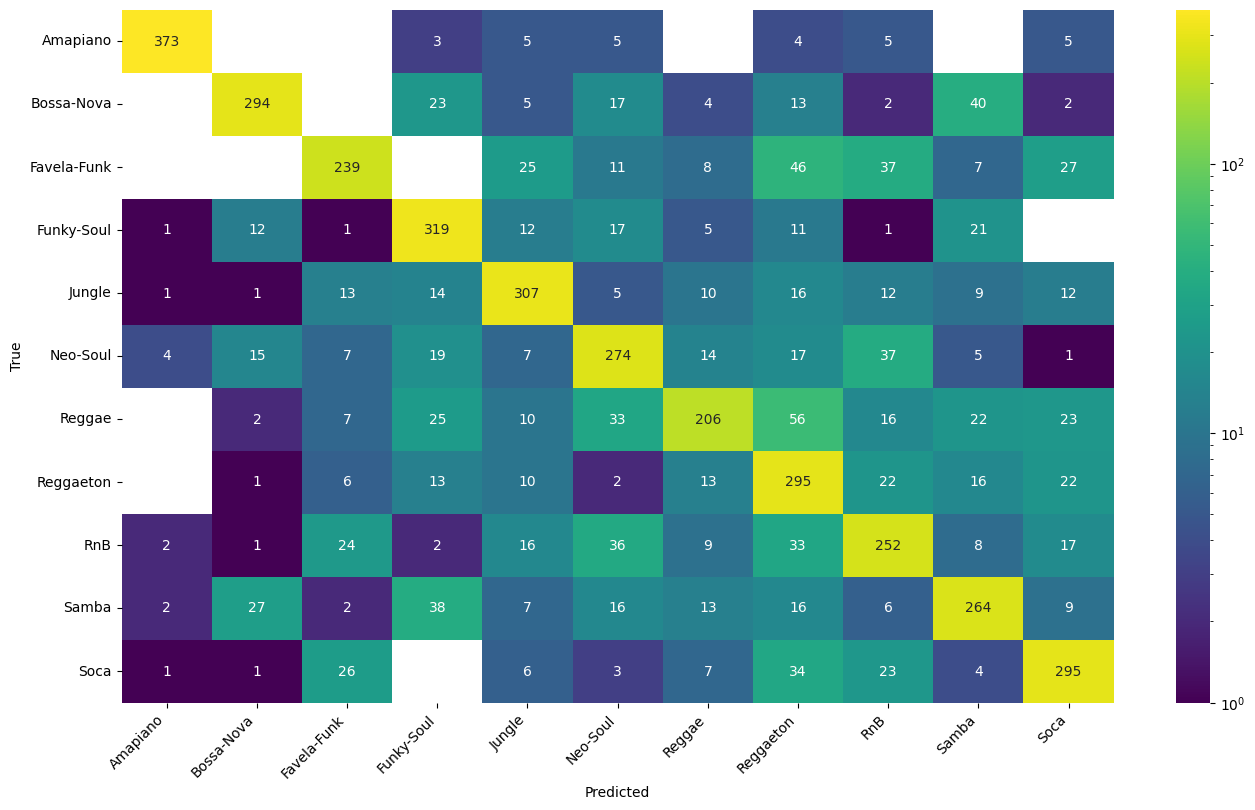

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

index_to_label = {index: label for label, index in label_mapping.items()}

true_labels_class = [index_to_label[label] for label in true_labels]
pred_labels_class = [index_to_label[label] for label in predicted_labels]


import seaborn as sns
from matplotlib.colors import LogNorm

unique_labels = np.unique(np.concatenate((true_labels_class, pred_labels_class)))


confusion_matr = confusion_matrix(true_labels_class, pred_labels_class) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="viridis", annot=True, fmt="d", norm=LogNorm(), xticklabels=unique_labels, yticklabels=unique_labels)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
accuracy_per_class = confusion_matr.diagonal() / confusion_matr.sum(axis=1)

# Print accuracy per class
for label, accuracy in zip(unique_labels, accuracy_per_class):
    print(f'Class: {label}, Accuracy: {accuracy:.2f}')

Class: Amapiano, Accuracy: 0.93
Class: Bossa-Nova, Accuracy: 0.73
Class: Favela-Funk, Accuracy: 0.60
Class: Funky-Soul, Accuracy: 0.80
Class: Jungle, Accuracy: 0.77
Class: Neo-Soul, Accuracy: 0.69
Class: Reggae, Accuracy: 0.52
Class: Reggaeton, Accuracy: 0.74
Class: RnB, Accuracy: 0.63
Class: Samba, Accuracy: 0.66
Class: Soca, Accuracy: 0.74


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_labels_class, pred_labels_class)
print(report)

              precision    recall  f1-score   support

    Amapiano       0.97      0.93      0.95       400
  Bossa-Nova       0.83      0.73      0.78       400
 Favela-Funk       0.74      0.60      0.66       400
  Funky-Soul       0.70      0.80      0.75       400
      Jungle       0.75      0.77      0.76       400
    Neo-Soul       0.65      0.69      0.67       400
      Reggae       0.71      0.52      0.60       400
   Reggaeton       0.55      0.74      0.63       400
         RnB       0.61      0.63      0.62       400
       Samba       0.67      0.66      0.66       400
        Soca       0.71      0.74      0.73       400

    accuracy                           0.71      4400
   macro avg       0.72      0.71      0.71      4400
weighted avg       0.72      0.71      0.71      4400



In [ ]:
model.save("final_model.keras")